# Gammel kode

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold, GridSearchCV

#load data from txt file with pandas
data = pd.read_csv('case1Data.txt', sep=", ", engine='python')
y = data['y']

X = pd.read_csv('case1Data_one_hot.csv').to_numpy()
X_new = pd.read_csv('case1Data_Xnew_one_hot.csv').to_numpy()
y_vec = y.values

In [ ]:
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, X_new = None):
        self.X_new = X_new
        self.scaler = StandardScaler()

    def fit(self, X, y = None):
        self.scaler.fit(np.concatenate((X[:,:95], self.X_new[:,:95]), axis = 0))
        #print('scaler fit')
        return self

    def transform(self, X, y = None):
        X_con = self.scaler.transform(X[:,:95])
        X = np.concatenate((X_con, X[:,95:]), axis = 1)
        return X
    
class CustomKNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=1, weights='distance', X_new = None):
        #print('CustomKNNImputer init')
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.X_new = X_new

    def fit(self, X, y = None):
        self.scaler = CustomScaler(X_new = self.X_new).fit(X)
        X_new_norm = self.scaler.transform(self.X_new)
        data = np.concatenate((X, X_new_norm), axis = 0)
        self.imputer = KNNImputer(n_neighbors = self.n_neighbors, weights = self.weights)
        self.imputer.fit(data)
        return self

    def transform(self, X, y = None):
        X = self.imputer.transform(X)
        N = X.shape[0]
        for i in range(N):
            for j in range(4):
                idx = np.argmax(X[i, 95+(j*5) : 95+(j+1)*5 ])
                X[i, 95+(j*5) : 95+(j+1)*5 ] = 0,0,0,0,0
                X[i, 95+(j*5) + idx] = 1
        return X
    
class Debugger(BaseEstimator, TransformerMixin):

    def transform(self, data):
        print("Shape of data at this point", data.shape)
        print(pd.DataFrame(data).head())
        return data

    def fit(self, data, y=None, **fit_params):
        # No need to fit anything, because this is not an actual  transformation. 
        return self

In [ ]:
from sklearn.linear_model import Lasso

# Define the pipeline
scaler = CustomScaler(X_new=X_new)
imputer = CustomKNNImputer(X_new = X_new)
model = Lasso(max_iter=10000)
pipe = Pipeline(steps=[('scale', scaler), ('impute', imputer), ('model', model)])

param_grid = {'impute__weights': ['uniform', 'distance'], 
              'impute__n_neighbors': range(3, 10), 
              'model__alpha': np.linspace(0.1, 3, 10)
              }

# Define the cross-validation
K_outer = 5
K_inner = 3
outer_cv = KFold(n_splits=K_outer, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=K_inner, shuffle=True, random_state=42)

# Perform the grid search
RMSE = np.zeros(K_outer)
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
    print(f"Running outer fold {i+1}/{K_outer}")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_vec[train_idx], y_vec[test_idx]
    search = GridSearchCV(pipe, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, refit = True)
    search.fit(X_train, y_train)
    best_params = search.best_params_

    pipe.set_params(**best_params)
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    #best_model = result.best_estimator_
    #preds = best_model.predict(X_test)

    RMSE[i] = np.sqrt(np.mean((preds - y_test)**2))
    print("Best parameter (CV score=%0.3f):" % search.best_score_, search.best_params_, 'RMSE:', f"{RMSE[i]:.3f}")


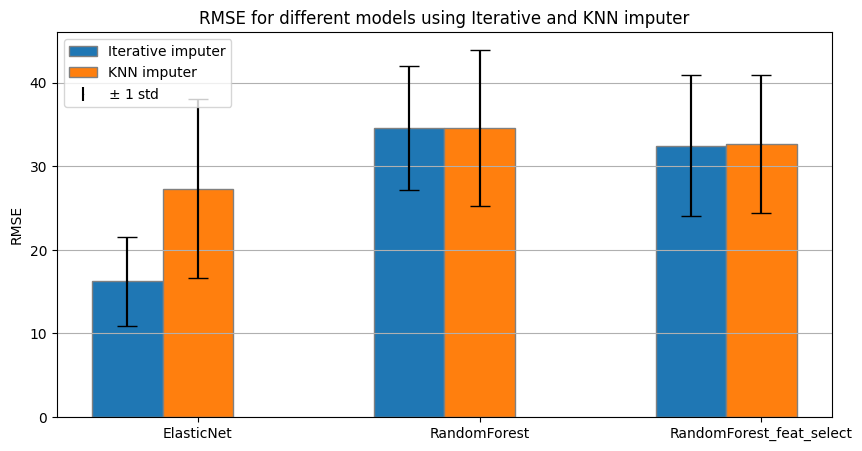

In [27]:
import pickle
RMSE_itt = pickle.load(open('RMSE_dict_iterativeImputer_test_featselect.pkl', 'rb'))
RMSE_knn = pickle.load(open("RMSE_dict_KNNimputer_test_featselect.pkl", 'rb'))

#Remove lars key from rmse dict
RMSE_itt.pop('Lars')
RMSE_knn.pop('Lars')
#plot the RMSE with lars
fig, ax = plt.subplots(1, 1, figsize = (10,5))

models = list(RMSE_itt.keys())
mean_itt = [round(RMSE_itt[model].mean(), 4) for model in models]
std_itt = [round(RMSE_itt[model].std(), 4) for model in models]
mean_knn = [round(RMSE_knn[model].mean(), 4) for model in models]
std_knn = [round(RMSE_knn[model].std(), 4) for model in models]

#make bar plot of RMSE of both imputers, first itterative and then knn so there will be 6 bars in total
barWidth = 0.25
r1 = np.arange(len(mean_itt))
r2 = [x + barWidth for x in r1]
ax.bar(r1, mean_itt, yerr=std_itt, width=barWidth, edgecolor='grey', label='Iterative imputer', capsize=7)
ax.bar(r2, mean_knn, yerr=std_knn, width=barWidth, edgecolor='grey', label='KNN imputer', capsize=7)
ax.errorbar(r1, mean_itt, yerr=std_itt, fmt='o', color='black', label='$\pm$ 1 std', markersize=0.1)
ax.errorbar(r2, mean_knn, yerr=std_knn, fmt='o', color='black', markersize=0.1)

ax.set_xticks([r + barWidth for r in range(len(mean_itt))])
ax.set_xticklabels(models)
ax.set_ylabel('RMSE')
ax.set_title('RMSE for different models using Iterative and KNN imputer')
ax.yaxis.grid(True)
ax.legend()



#ax[0].bar(models, mean_itt, yerr=std_itt, align='center', alpha=0.5, ecolor='black', capsize=10, label='Mean RMSE')
#ax[0].errorbar(models, mean_itt, yerr=std_itt, fmt='o', color='black', label='$\pm$ 1 std', markersize=0.1)
#ax[0].legend()
#ax[0].set_ylabel('RMSE')
#ax[0].set_title('RMSE for different models using Iterative imputer')
#ax[0].yaxis.grid(True)

    #save the figure
#plt.savefig('RMSE_models_iterativeImputer_test_featselect.png')

In [31]:
for key in RMSE_itt.keys():
    print(key, RMSE_itt[key].mean(), RMSE_itt[key].std())

print()
for key in RMSE_knn.keys():
    print(key, RMSE_knn[key].mean(), RMSE_knn[key].std())

ElasticNet 16.21352460536583 5.2928219050357885
RandomForest 34.5661067451321 7.4222415484076825
RandomForest_feat_select 32.46315018639217 8.432358564317363

ElasticNet 27.32652099539419 10.686573509018805
RandomForest 34.530539809535576 9.298971113106708
RandomForest_feat_select 32.67465480752043 8.280608250911563


In [36]:
RMSE_lasso = pickle.load(open('RMSE_dict_final.pkl', 'rb'))

RMSE_lasso

for key in RMSE_lasso.keys():
    print(key, RMSE_lasso[key].mean(), RMSE_lasso[key].std())


#Save mean RMSE for lasso as txt file
with open('RMSE_lasso.txt', 'w') as f:
    for key in RMSE_lasso.keys():
        f.write(f'{RMSE_lasso[key].mean()}')

Lasso 16.184479200179673 5.020335554665264


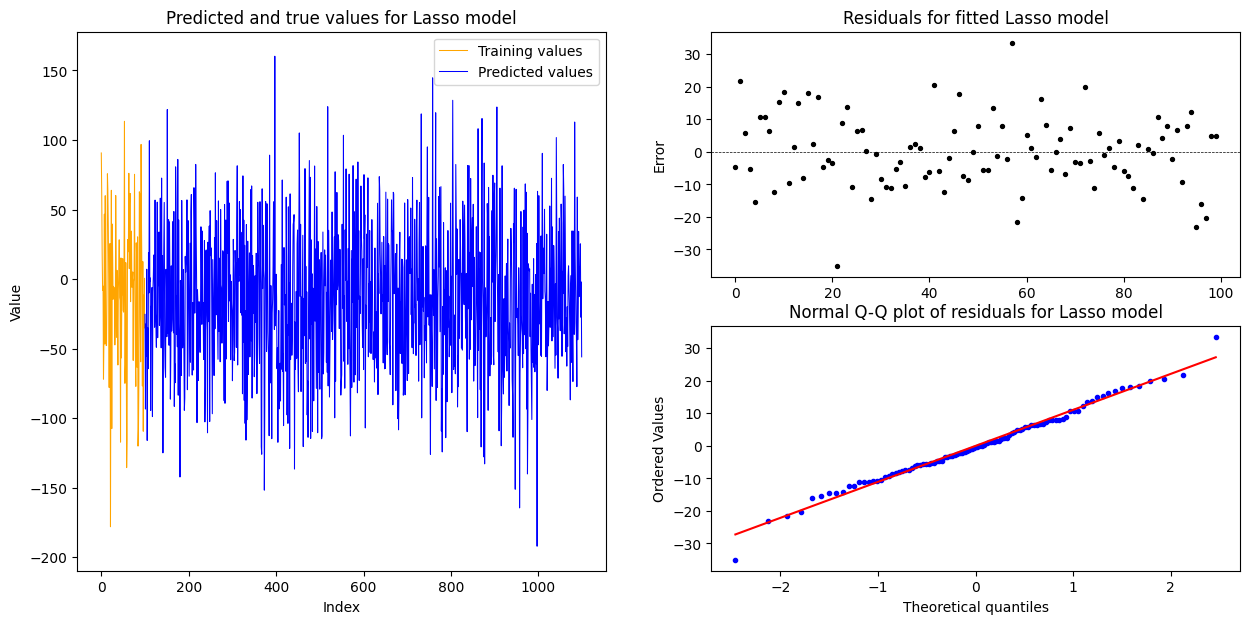

In [155]:
residuals = np.loadtxt('residuals.txt')

#plt.plot(residuals, 'o')

#plt.show()
from matplotlib.gridspec import GridSpec

preds = np.loadtxt("case1Data_yhat_lasso.txt")

tmp = np.concatenate((y_vec, preds), axis = 0)

#plot with y_vec part oragne and preds part blue

gs = GridSpec(2, 2, figure = plt.figure(figsize = (15, 7)))

ax0 = plt.subplot(gs[:, 0])

ax0.plot(range(0,100), tmp[:100], '-', color = 'orange', label = 'Training values', linewidth = 0.75)
ax0.plot(range(100, 1100), tmp[100:], '-', color = 'blue', label = 'Predicted values', linewidth = 0.75)
ax0.set_xlabel('Index')
ax0.set_ylabel('Value')
ax0.legend()
ax0.set_title('Predicted and true values for Lasso model')

ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, 1])

ax1.scatter(range(100), residuals, color = 'black', s = 8, label = 'Residuals')
ax1.axhline(0, color='black', lw=0.5, linestyle='--')
ax1.set_ylabel('Error')
ax1.set_title('Residuals for fitted Lasso model')

stats.probplot(residuals, dist="norm", plot=ax2)
for line in ax2.get_lines():
    line.set_markersize(3)
ax2.set_title('Normal Q-Q plot of residuals for Lasso model')
ax2.set_xlabel('Theoretical quantiles')
ax2.set_ylabel('Ordered Values')
plt.show()






In [97]:
#convert pred values to list and save to txt file
preds = preds.tolist()

with open('case1Data_preds_final.txt', 'w') as f:
    for pred in preds:
        f.write(f'{pred}\n')

In [ ]:
ax[0,0].plot(range(0,100), tmp[:100], '-', color = 'orange', label = 'Training values', linewidth = 0.75)
ax[0,0].plot(range(100, 1100), tmp[100:], '-', color = 'blue', label = 'Predicted values', linewidth = 0.75)
ax[0,0].set_xlabel('Index')
ax[0,0].set_ylabel('Value')
ax[0,0].legend()
ax[0,0].set_title('Predicted and true values for Lasso model')

#scatter of residuals
#ax[1].scatter(range(100), residuals, color = 'black', s = 8, label = 'Residuals')
#ax[1].axhline(0, color='black', lw=0.5, linestyle='--')
#ax[1].set_xlabel('Index')
#ax[1].set_ylabel('Error')
#ax[1].set_title('Residuals for fitted Lasso model')

#Make qq-plot of residuals in ax[1]
import scipy.stats as stats
import matplotlib.pyplot as plt

#stats.probplot(residuals, dist="norm", plot=plt)
#plt.title('Normal Q-Q plot')
#plt.xlabel('Theoretical quantiles')
#plt.ylabel('Ordered Values')
#plt.show()